In [1]:
import os
import itk
import itkwidgets
import numpy as np
import matplotlib.pyplot as plt
import parent
import test
from test.test_all import TEST_DATA_DIR
from test.test_all import download_test_data
download_test_data()

In [6]:
#test_volume = itk.imread(os.path.join(TEST_DATA_DIR, "colab_case/image_preprocessed.nii.gz"))
#test_volume = itk.imread('/media/pranjal.sahu/moredata/OAI-MATT/9298954_20050422_10384306_left-20220531T150108Z-001/9298954_20050422_10384306_left.nii.gz')


test_volume = itk.imread('/media/pranjal.sahu/moredata/OAI-MATT/20051007/10101107.nii.gz')
# works fine
#test_volume = itk.imread('/media/pranjal.sahu/moredata/OAI-MATT/20051007/10101103.nii.gz')
#test_volume = itk.imread('/media/pranjal.sahu/moredata/OAI-MATT/20051007/10101109.nii.gz')
test_volume = itk.imread('/media/pranjal.sahu/moredata/OAI-MATT/20051007/10101114.nii.gz')

In [7]:
itkwidgets.view(test_volume)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; pro…

In [4]:
import oai_analysis_2
obj = oai_analysis_2.AnalysisObject()
FC, TC = obj.segment(test_volume)

Loading parameter file = /home/pranjal.sahu/OAI/OAI_analysis_2/data/segmentation_train_config.pth.tar
=> loading checkpoint '/home/pranjal.sahu/OAI/OAI_analysis_2/data/segmentation_model.pth.tar'
=> loaded checkpoint '/home/pranjal.sahu/OAI/OAI_analysis_2/data/segmentation_model.pth.tar' (epoch 600)


In [5]:
itkwidgets.view(FC)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageD3; pro…

In [29]:
# Read the dicom image series

import itk
import glob
import os

dirName = '/media/pranjal.sahu/moredata/OAI-MATT/20051007/10101101'
#dirName = '/media/pranjal.sahu/moredata/OAI-MATT/9298954_20050422_10384306_left-20220531T150108Z-001/9298954_20050422_10384306_left'

def image_normalize(image, window_min_perc, window_max_perc, output_min, output_max):
    window_rescale = itk.IntensityWindowingImageFilter[type(image), type(image)].New()
    image_array = itk.GetArrayFromImage(image)
    
    window_min = np.percentile(image_array, window_min_perc)
    window_max = np.percentile(image_array, window_max_perc)
    
    window_rescale.SetInput(image)
    window_rescale.SetOutputMaximum(output_max)
    window_rescale.SetOutputMinimum(output_min)
    window_rescale.SetWindowMaximum(window_max)
    window_rescale.SetWindowMinimum(window_min)
    window_rescale.Update()
    
    return window_rescale.GetOutput()

def get_normalized_image(dirName):
    PixelType = itk.ctype("signed short")
    Dimension = 3

    ImageType = itk.Image[PixelType, Dimension]

    namesGenerator = itk.GDCMSeriesFileNames.New()
    namesGenerator.SetUseSeriesDetails(True)
    namesGenerator.AddSeriesRestriction("0008|0021")
    namesGenerator.SetGlobalWarningDisplay(False)
    namesGenerator.SetDirectory(dirName)

    seriesUID = namesGenerator.GetSeriesUIDs()
    
    for uid in seriesUID:
        seriesIdentifier = uid
        fileNames = namesGenerator.GetFileNames(seriesIdentifier)

        reader  = itk.ImageSeriesReader[ImageType].New()
        dicomIO = itk.GDCMImageIO.New()
        reader.SetImageIO(dicomIO)
        reader.SetFileNames(fileNames)
        reader.ForceOrthogonalDirectionOff()
        reader.Update()
        image = reader.GetOutput()
        
        metadata = dicomIO.GetMetaDataDictionary()
        #print('key is ', metadata['0008|103e'])
    
        float_filter = itk.CastImageFilter[type(image), itk.Image.F3].New()
        float_filter.SetInput(image)
        float_filter.Update()
        image = float_filter.GetOutput()
        
        img_normalized = image_normalize(image, 0.1, 99.9, 0, 1)
        
        return img_normalized, metadata['0008|103e']
        

#folder_name = '/media/pranjal.sahu/moredata/OAI-MATT/9298954_20050422_10384306_left-20220531T150108Z-001/'
folder_name = '/media/pranjal.sahu/moredata/OAI-MATT/20051007/'

all_names = glob.glob(folder_name+'*')
for name in all_names:
    if os.path.isdir(name):
        normalized_img, metadata = get_normalized_image(name)
        if 'DESS' in metadata:
            new_name =  name + '_' + metadata.split('_')[-1].strip()+'.nii.gz'
            print(new_name, normalized_img.shape, metadata)
            itk.imwrite(normalized_img, new_name)

/media/pranjal.sahu/moredata/OAI-MATT/20051007/10101109_RIGHT.nii.gz (160, 384, 384) SAG_3D_DESS_RIGHT 
/media/pranjal.sahu/moredata/OAI-MATT/20051007/10101103_LEFT.nii.gz (160, 384, 384) SAG_3D_DESS_LEFT


In [18]:
dirName = '/media/pranjal.sahu/moredata/OAI-MATT/20051007/10101103/'

PixelType = itk.ctype("signed short")
Dimension = 3
ImageType = itk.Image[PixelType, Dimension]
    
namesGenerator = itk.GDCMSeriesFileNames.New()
namesGenerator.SetUseSeriesDetails(True)
namesGenerator.AddSeriesRestriction("0008|0021")
namesGenerator.SetGlobalWarningDisplay(False)
namesGenerator.SetDirectory(dirName)

seriesUID = namesGenerator.GetSeriesUIDs()

print(seriesUID)

for uid in seriesUID:
    seriesIdentifier = uid
    fileNames = namesGenerator.GetFileNames(seriesIdentifier)

    reader  = itk.ImageSeriesReader[ImageType].New()
    dicomIO = itk.GDCMImageIO.New()
    dicomIO.LoadPrivateTagsOn()
    
    reader.SetImageIO(dicomIO)
    reader.SetFileNames(fileNames)
    reader.ForceOrthogonalDirectionOff()
    reader.Update()
    image = reader.GetOutput()
    
    metadata = dicomIO.GetMetaDataDictionary()
    
    print('key is ', metadata['0008|103e'])

('1.3.12.2.1107.5.2.13.20576.4.0.4671522628072110.3de3d10.6999999938438420051007',)
key is  SAG_3D_DESS_LEFT


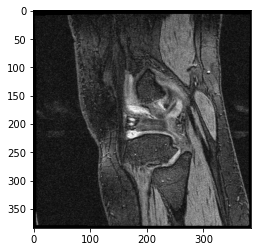

In [46]:
plt.imshow(normalized_img[32], cmap='gray')

In [28]:
itk.imwrite(img_normalized, 'img_normalized.nii.gz')

In [2]:
import sys
import itk
import numpy as np
from distutils.version import StrictVersion as VS
from scipy import ndimage as ndi
from skimage.morphology import disk
from scipy.ndimage import shift


# if VS(itk.Version.GetITKVersion()) < VS("5.3.0"):
#     print("ITK 5.3.0 is required.")
#     sys.exit(1)

# Draw a 3D disk
side_size = 10
obj2d = disk(side_size / 2, dtype=np.uint8)
obj3d = np.asarray([disk(side_size / 2, dtype=np.uint8)
                    for idx in range(5)])
# Create 4 frames
series_length = 4
holder = np.asarray([obj3d for idx in range(series_length)])
# Move the last frame
holder[-1] = shift(holder[-1],
                   (series_length - 1, 0, 0))

fixed_image_arr = holder[0].transpose((2, 1, 0))
moving_image_arr = holder[-1].transpose((2, 1, 0))
fixed_image = itk.image_from_array(
    fixed_image_arr.astype(np.float32))
moving_image = itk.image_from_array(
    moving_image_arr.astype(np.float32))

spatial_dim = fixed_image.GetImageDimension()
fixed_image_type = type(fixed_image)
moving_image_type = type(moving_image)

origin = [0] * spatial_dim
length_per_px_ratios = [1] * spatial_dim
[dict(img).update({
    # Set origin ([0, 0, 0]); fixed_image.GetOrigin()
    "origin": origin,
    # Axial scale (length unit / pixel for each axis)
    "spacing": length_per_px_ratios,
    # Set orientation of axes; fixed_image.GetDirection()
    "direction": np.eye(spatial_dim)})
 for img in (fixed_image, moving_image)]

coord_type = itk.D
versor_type = coord_type
versor_transform_class = itk.VersorRigid3DTransform[versor_type]
rigid_transform = versor_transform_class.New()
trnfm_init_class = itk.CenteredTransformInitializer[
    # versor_transform_class,
    itk.VersorRigid3DTransform[itk.D],
    fixed_image_type,
    moving_image_type]
optimiser_class = itk.RegularStepGradientDescentOptimizer
optimiser = optimiser_class.New()
metric = itk.MattesMutualInformationImageToImageMetric[
    fixed_image_type, moving_image_type].New(
        NumberOfHistogramBins=50)
metric.ReinitializeSeed(76926294)
metric.SetUseCachingOfBSplineWeights(True)
metric.SetUseExplicitPDFDerivatives(True)
interpolator = itk.LinearInterpolateImageFunction[
    moving_image_type, coord_type].New()
registrant = itk.ImageRegistrationMethod[
    fixed_image_type, moving_image_type].New(
        Metric=metric,
        Optimizer=optimiser,
        Interpolator=interpolator,
        FixedImage=fixed_image,
        MovingImage=moving_image)

identity_transform = itk.IdentityTransform[
    coord_type, spatial_dim].New()

initialiser = trnfm_init_class.New(
    Transform=rigid_transform,
    FixedImage=fixed_image,
    MovingImage=moving_image)
initialiser.MomentsOn()
initialiser.InitializeTransform()
fixed_region = fixed_image.GetBufferedRegion()
number_of_pixels = fixed_region.GetNumberOfPixels()
registrant.SetFixedImageRegion(fixed_region)
registrant.SetInitialTransformParameters(
    rigid_transform.GetParameters())
registrant.SetTransform(rigid_transform)

translation_scale = 1 / 1000
optimiser_scales = [1.0, 1.0, 1.0,
                    translation_scale,
                    translation_scale,
                    translation_scale]
optimiser.SetScales(optimiser_scales)
optimiser.SetMaximumStepLength(0.2000)
optimiser.SetMinimumStepLength(0.0001)
optimiser.SetNumberOfIterations(200)

metric.SetNumberOfSpatialSamples(int(10000))
registrant.Update()
rigid_transform.SetParameters(registrant.GetLastTransformParameters())

affine_transform_class = itk.AffineTransform[
    coord_type, spatial_dim]
affine_transform = affine_transform_class.New(
    Center=rigid_transform.GetCenter(),
    Translation=rigid_transform.GetTranslation(),
    Matrix=rigid_transform.GetMatrix())
registrant.SetTransform(affine_transform)
registrant.SetInitialTransformParameters(
    affine_transform.GetParameters())
optimiser.SetScales([1] * 9 + [translation_scale] * 3)
optimiser.SetMaximumStepLength(0.2)
optimiser.SetMinimumStepLength(1e-4)
optimiser.SetNumberOfIterations(200)
metric.SetNumberOfSpatialSamples(int(50000))

registrant.Update()

affine_transform.SetParameters(registrant.GetLastTransformParameters())

spline_order = 3
deformable_transform_class = itk.BSplineTransform[
    coord_type, spatial_dim, spline_order]
bspline_transform_coarse = deformable_transform_class.New()
grid_nodes_1_dim_coarse = int(5)
fixed_origin = fixed_image.GetOrigin()
fixed_physical_dimensions = [fixed_image.GetSpacing()[idx] * (
    fixed_image.GetLargestPossibleRegion().GetSize()[idx] - 1)
                             for idx in range(spatial_dim)]
bspline_transform_coarse.SetTransformDomainOrigin(fixed_origin)
bspline_transform_coarse.SetTransformDomainPhysicalDimensions(
    fixed_physical_dimensions)
mesh_size = \
    bspline_transform_coarse.GetTransformDomainMeshSize()
mesh_size.Fill(grid_nodes_1_dim_coarse - spline_order)
bspline_transform_coarse.SetTransformDomainMeshSize(mesh_size)
bspline_transform_coarse.SetTransformDomainDirection(
    fixed_image.GetDirection())
number_of_bspline_param = \
    bspline_transform_coarse.GetNumberOfParameters()
optimiser.SetScales(
    [1.0 for idx in range(number_of_bspline_param)])
composite_transform_class = itk.CompositeTransform[
    coord_type, spatial_dim]
composite_transform = composite_transform_class.New()
composite_transform.AddTransform(affine_transform)
composite_transform.AddTransform(bspline_transform_coarse)
composite_transform.SetOnlyMostRecentTransformToOptimizeOn()
bspline_transform_coarse.GetParameters().Fill(1.0)
registrant.SetInitialTransformParameters(
    bspline_transform_coarse.GetParameters())
registrant.SetTransform(composite_transform)

optimiser.SetMaximumStepLength(10.0)
optimiser.SetMinimumStepLength(0.01)
optimiser.SetRelaxationFactor(0.7)
optimiser.SetNumberOfIterations(50)

metric.SetNumberOfSpatialSamples(number_of_bspline_param * 100)
registrant.Update()
final_parameters = registrant.GetLastTransformParameters()
bspline_transform_coarse.SetParameters(final_parameters)


bspline_transform_fine = deformable_transform_class.New(
    TransformDomainOrigin=fixed_origin,
    TransformDomainPhysicalDimensions=fixed_physical_dimensions,
    TransformDomainMeshSize=mesh_size,
    TransformDomainDirection=fixed_image.GetDirection())
grid_nodes_1_dim_fine = int(20)
mesh_size.Fill(grid_nodes_1_dim_fine - spline_order)
number_of_bspline_param = \
    bspline_transform_fine.GetNumberOfParameters()

interpolator_fine = itk.BSplineResampleImageFunction[
    moving_image_type, coord_type].New()

upsampler = itk.ResampleImageFilter[moving_image_type, moving_image_type].New(
    Input=bspline_transform_coarse.GetCoefficientImages(),
    Interpolator=interpolator_fine,
    Transform=identity_transform,
    Size=bspline_transform_fine.GetCoefficientImages())

upsampler = itk.resample_image_filter[moving_image_type, moving_image_type](
    Input=bspline_transform_coarse.GetCoefficientImages()[0],
    interpolator=interpolator_fine,
    transform=identity_transform,
    size=bspline_transform_fine.GetCoefficientImages())

TypeError: Expecting argument of type itkImageF3 or itkImageSourceIF3.
Additional information:
Wrong number or type of arguments for overloaded function 'itkImageToImageFilterIF3IF3_SetInput'.
  Possible C/C++ prototypes are:
    itkImageToImageFilterIF3IF3::SetInput(itkImageF3 const *)
    itkImageToImageFilterIF3IF3::SetInput(unsigned int,itkImageF3 const *)


In [12]:
print(bspline_transform_coarse.iterator)

AttributeError: 'itkBSplineTransformD33' object has no attribute 'iterator'

In [13]:
t1 = bspline_transform_coarse.GetCoefficientImages()
print(t1.iterator)

AttributeError: 'SwigPyObject' object has no attribute 'iterator'

In [14]:
print(t1)

<Swig Object of type 'itk::FixedArray< itk::SmartPointer< itk::Image< double,3 > >,3 > *' at 0x7f0e70f9f5d0>


In [18]:
t1.size()

AttributeError: 'SwigPyObject' object has no attribute 'size'